## Installing "standalone" Sherpa

For installation instructions, please follow the [Sherpa installation documentation](https://sherpa.readthedocs.io/en/latest/install.html).

## Last run

When was this notebook last run?

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2024-09-30 11:34'

In [2]:
# This will only work once Sherpa has been installed, which we haven't mentioned yet!
import sherpa
sherpa.__version__

'4.17.0'

We can look at what versions of packages-we-care-about™ are installed:

In [3]:
!pip list | egrep 'astropy|matplotlib|scipy|sherpa'

astropy                   6.1.4
astropy-iers-data         0.2024.9.30.0.32.59
matplotlib                3.9.2
matplotlib-inline         0.1.7
scipy                     1.14.1
sherpa                    4.17.0


To get the notebooks I clone the notebook repository:

    % git clone https://github.com/DougBurke/sherpa-standalone-notebooks
    % cd sherpa-standalone-notebooks
    % jupyter lab
    
and a page containing the following is now visible in my web browser (you will see something slightly different as there have been a few notebooks added since I made this screen shot, and I've changed from suggesting `jupyter notebook` to `jupyter lab`):

![A list of notebooks is given, one of which is "simple sherpa fit"](images/notebook-start.png)

Selecting the "simple sherpa fit" option creates a new page containing this (user-editable) notebook, and the initial page changes to show that a notebook is running:

![The "simple sherpa fit" notebook is now marked as "running"](images/notebook-simple-running.png)

## The Sherpa UI

As Sherpa is a set of routines, there are several ways to use it. The main ones are

 1 using the `sherpa.astro.ui` module, which provides data management
   capabilities on top of the fitting routines
   
 2 a low-level API where for those times when the UI layer is not
   needed.

We start with a brief exploration of the UI layer, using it to replicate
the simple one-dimensional polynomial fits from the [Python for Astronomers
"Introduction to NumPy and SciPy"](http://python4astronomers.github.io/core/numpy_scipy.html)
guide. Although it is more involved than the original version, which
uses the NumPy `polyfit` and `polyval` routines to fit a polynomial,
it is not that much more work, and the advantage is that it is easy
to change the model to fit a different, perhaps more-complicated,
model.

We then follow with a run through of the same fit, this time using the
lower-level API.

To start with - and as a check that everything is okay - I load the Sherpa `ui` module:

In [4]:
from sherpa.astro import ui

Since Sherpa has several optional parts, warning messages will be displayed when some of the parts
are not available. I am using the CIAO install which has all the required optional packages, but
if you use the standalonie Sherpa installation you may see warnings about DS9 and XSPEC, which you 
can ignore here.

For this notebook I need to download and unpack the data from the
[Python for Astronomers](https://python4astronomers.github.io/core/numpy_scipy.html)
site; the following code is taken from that page (if you have problems following
along please review the page to see if the instructions have changed since I last updated
this notebook).

In [5]:
from urllib.request import urlopen
import tarfile
url = 'http://python4astronomers.github.io/_downloads/core_examples.tar'
tarfile.open(fileobj=urlopen(url), mode='r|').extractall()

/tmp/ipykernel_2488997/2639785539.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open(fileobj=urlopen(url), mode='r|').extractall()


The data is in a subdirectory, so I take advantage of the IPython support for basic shell commands
and move there:

In [6]:
cd py4ast/core

/lagado.real/sherpa/sherpa-standalone-notebooks/py4ast/core


/lagado2.real/local/anaconda/envs/sherpa_test/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Now I can read in the data using the AstroPy FITS reader:

In [7]:
from astropy.io import fits
hdus = fits.open('3c120_stis.fits.gz')

Please see the 
[original guide](https://python4astronomers.github.io/core/numpy_scipy.html#read-in-the-2-d-image)
from the `Python 4 Astronomers` course for information on what the following is doing:

In [8]:
primary = hdus[0].data  # Primary (NULL) header data unit
img = hdus[1].data      # Intensity data
err = hdus[2].data      # Error per pixel
dq = hdus[3].data       # Data quality per pixel

The following statement makes the matplotlib plots appear inline and sets up the `plt` namespace:

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

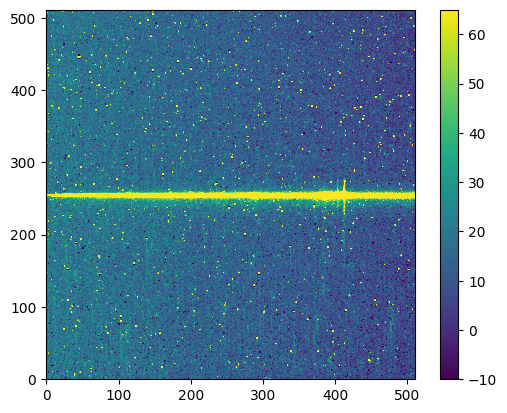

In [10]:
plt.imshow(img, origin = 'lower', vmin = -10, vmax = 65)
plt.colorbar()

It is this image that we are going to clean of cosmic rays (using SciPy) and to subtract a
simple estimate of the background (using Sherpa).

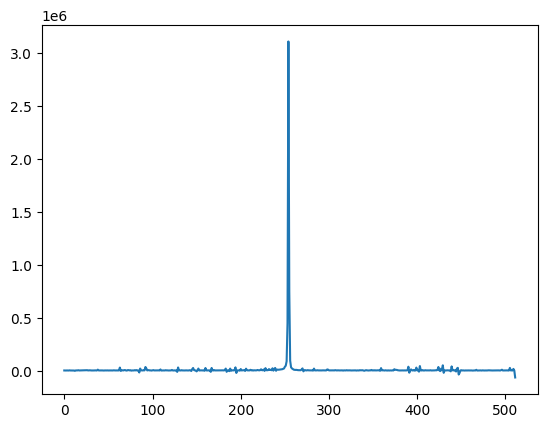

In [11]:
profile = img.sum(axis=1)
plt.figure()
plt.plot(profile);

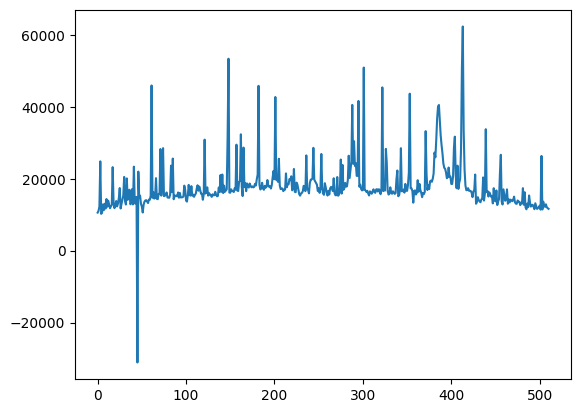

In [12]:
spectrum = img.sum(axis=0)
plt.figure()
plt.plot(spectrum);

Cosmic rays are removed using a simple median-filter approach:

In [13]:
import scipy.signal
import numpy as np

# NOTE: this has been changed from scipy.signal.medfilt as that now complains about
# being sent a floating-point array. Yay progress.
img_sm = scipy.signal.medfilt2d(img, 5)
sigma = np.median(err)
bad = np.abs(img - img_sm) / sigma > 8.0
img_cr = img.copy()
img_cr[bad] = img_sm[bad]
img_cr[230:280,:] = img[230:280,:]  # Filter only for background

In [14]:
x = np.append(np.arange(10, 200), np.arange(300, 480))  # Background rows
y = img_cr[x, 10]         # Background rows of column 10 of cleaned image

I now "load" the data for the column into Sherpa, as dataset 1 (the `ui` layer of Sherpa handles
data management, using identifiers to refer to a particular dataset). The `load_arrays` command is
the only time here in which we will use the dataset identifier, since the default is to
either use dataset 1 or to use all loaded datasets (depending on the command).

Since we do not have errors here, we switch to the least-squares statistic, stop Sherpa
from adding error bars to the Y axis, and then plot up the data.

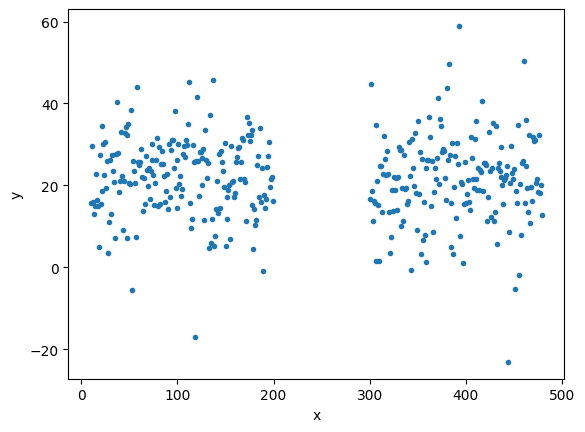

In [15]:
ui.load_arrays(1, x, y)
ui.set_stat('leastsq')
ui.get_data_plot_prefs()['yerrorbars'] = False
ui.plot_data()

The [original guide](https://python4astronomers.github.io/core/numpy_scipy.html#fit-the-background)
used a simple polynomial model to fit the data, so I will do the same. The syntax `ui.<modelname>.<instance name>` - e.g. `ui.polynom1d.mdl` - creates a variable called `<instance name>` (so `mdl` here) which is an instance of the model class (in this case a one-dimensional polynomial). It lets us "name" models, which can be useful in more-complicated scenarios, where the data has to be modelled as a combination of models. The `ui.set_source` call associates a model expression with a dataset (if not given it defaults to the default dataset).

In [16]:
ui.set_source(ui.polynom1d.mdl)

The model instance can be dislayed:

In [17]:
mdl

<Polynom1D model instance 'polynom1d.mdl'>

## Model documentation

Model documentation is available for the model *instance*, so `help(<instance name>)` should now provide information on what the parameters means (as well as a lot of other information!).

In [18]:
help(mdl)

Help on Polynom1D in module sherpa.models.basic object:

class Polynom1D(sherpa.models.model.RegriddableModel1D)
 |  Polynom1D(name='polynom1d')
 |
 |  One-dimensional polynomial function of order 8.
 |
 |  The maximum order of the polynomial is 8. The default setting has
 |  all parameters frozen except for ``c0``, which means that the
 |  model acts as a constant.
 |
 |  Attributes
 |  ----------
 |  c0
 |      The constant term.
 |  c1
 |      The amplitude of the (x-offset) term.
 |  c2
 |      The amplitude of the (x-offset)^2 term.
 |  c3
 |      The amplitude of the (x-offset)^3 term.
 |  c4
 |      The amplitude of the (x-offset)^4 term.
 |  c5
 |      The amplitude of the (x-offset)^5 term.
 |  c6
 |      The amplitude of the (x-offset)^6 term.
 |  c7
 |      The amplitude of the (x-offset)^7 term.
 |  c8
 |      The amplitude of the (x-offset)^8 term.
 |  offset
 |      There is a degeneracy between ``c0`` and ``offset``, so it
 |      is recommended that at least one of thes

Note that, when displaying the model, the `Thawed` field above has `thawed` only for one parameter - `c0` - which is not sufficient here,
as we want to fit the slope and not just the overall normalization. We therefore use the `thaw` command
to tell Sherpa that the `c1` parameter should also be fit.

The `guess` command tries to set the model parameters to something sensible: in most
cases this is limited to a change in normalization, but you can also see that the range of
the thawed parameters has also been changed here.

In [19]:
ui.thaw(mdl.c1)
ui.guess(mdl)
mdl

<Polynom1D model instance 'polynom1d.mdl'>

The `plot_fit` command displays the data and the current model (even if no fit has been made):

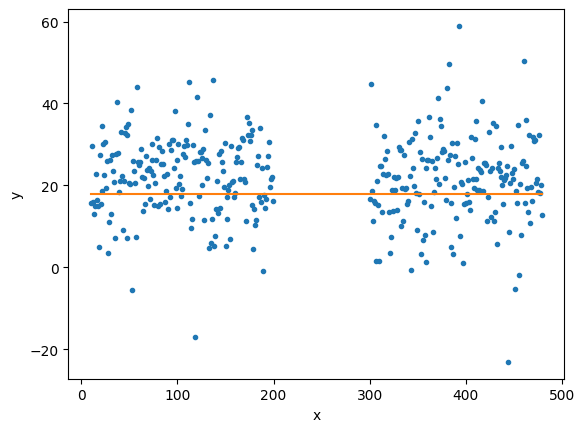

In [20]:
ui.plot_fit()

In this case the fit is very quick:

In [21]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 41778.4
Final fit statistic   = 36134.3 at function evaluation 6
Data points           = 370
Degrees of freedom    = 368
Change in statistic   = 5644.1
   mdl.c0         22.3585      +/- 0.0980054   
   mdl.c1         -0.00227968  +/- 0.000341686 


Added in CIAO 4.16 is the `get_plot_prefs` call, which makes it easy to change the preferences for the residual
plot. In this  case we want to hide the error bars:

In [22]:
ui.get_plot_prefs('resid')['yerrorbars'] = False

The `plot_fit_resid` command displays the data and best-fit in the top plot, and "data - best-fit"
in the bottom plot:

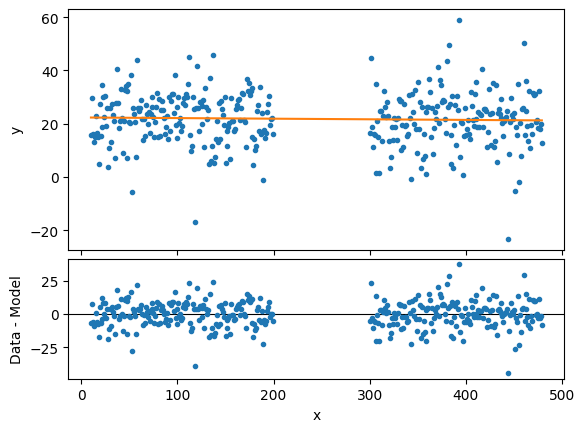

In [23]:
ui.plot_fit_resid()

Note that the model parameters have been updated by the `fit` command:

In [24]:
mdl

<Polynom1D model instance 'polynom1d.mdl'>

The following is a copy of the code from the original guide, but using Sherpa for the
fit and model evaluation. Note that you can evaluate a model component - such as `mdl` - on
an arbitrary grid (in this case `xrows`).

The `out0` and `out1` arrays are used to store the best-fit parameters for each
column; a better approach would be to allocate a numpy array and fill it up
rather than use a Python list, but it doesn't make much difference in this case!

Since we are going to loop through each column, performing a fit, the screen
output from the `fit` command will be overwhelming, and not very useful.
So we hide it with the `SherpaVerbosity` context manager (added in the 4.14 release,
before this you had to change the Sherpa logging instance directly, which you can
still do if you want).

In [25]:
from sherpa.utils.logging import SherpaVerbosity  # new in Sherpa/CIAO 4.14

xrows = np.arange(img_cr.shape[0])                # Array from 0 .. N_rows-1
bkg = np.zeros_like(img_cr)                       # Empty image for background fits
out0 = []                                         # Store the best-fit values
out1 = []
for col in np.arange(img_cr.shape[1]):            # Iterate over columns
    ui.load_arrays(1, x, img_cr[x, col])
    # note: in this case use the previous best-fit value as
    # a starting point for the next fit; really should be
    # resetting the values to be safe, although in this case
    # we may expect the fit values to be similar
    with SherpaVerbosity('ERROR'):
        ui.fit()
        
    out0.append(mdl.c0.val)                       # Use .val to get at the numeric value
    out1.append(mdl.c1.val)
    bkg[:, col] = mdl(xrows)                      # Evaluate the model for all rows

Out of interest, let's see how the model parameter values vary by column and against each other (this can be done directly with matplotlibbut there are some helper routines in Sherpa that may be helpful):

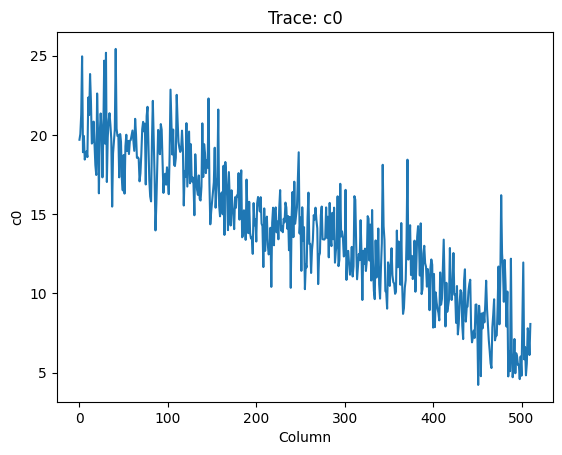

In [26]:
ui.plot_trace(out0, name="c0")
plt.xlabel("Column");

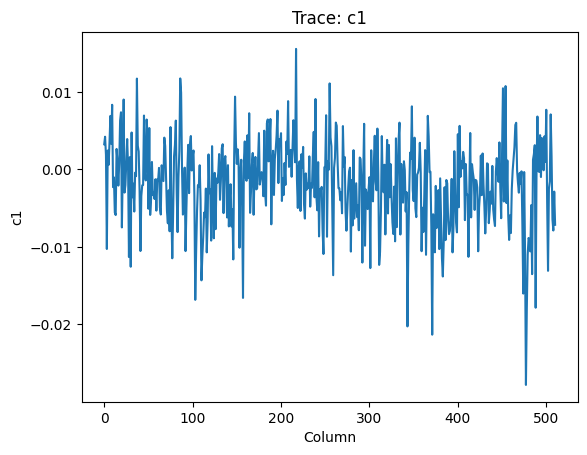

In [27]:
ui.plot_trace(out1, name="c1")
plt.xlabel("Column");

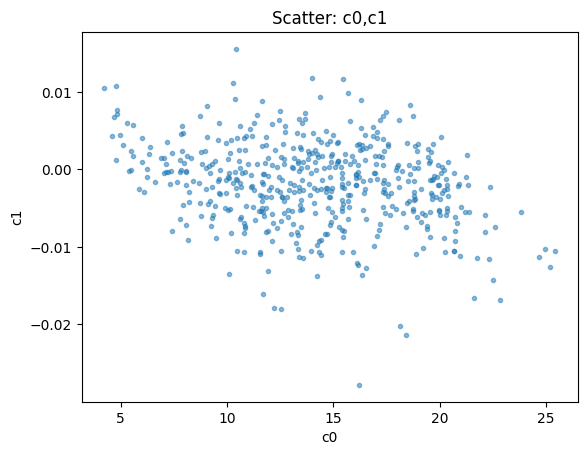

In [28]:
ui.plot_scatter(out0, out1, xlabel="c0", ylabel="c1", name="c0,c1", alpha=0.5)

As expected, the normalization values are correlated, whereas it's not so obvious for the slope.

How does the background-subtracted version compare to the original guide? Well, the following plots show they are similar,
but I have not done a close comparison to see how much difference there is.

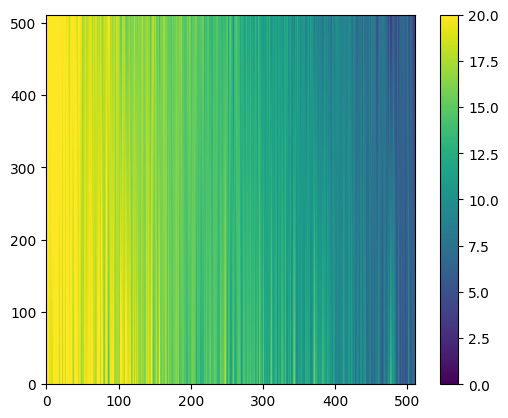

In [29]:
plt.imshow(bkg, origin = 'lower', vmin=0, vmax=20)
plt.colorbar();

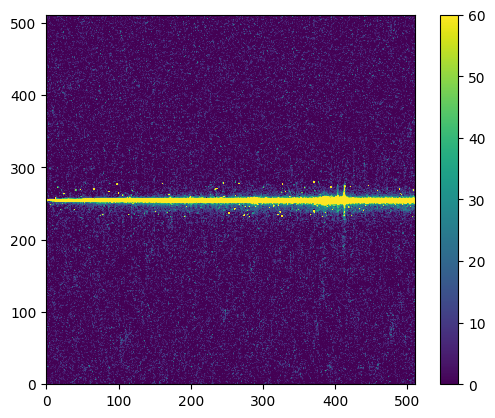

In [30]:
img_bkg = img_cr - bkg
plt.clf()
plt.imshow(img_bkg, origin = 'lower', vmin=0, vmax=60)
plt.colorbar();

The result can be compared to that obtained on the
[Python 4 Astronomers](https://python4astronomers.github.io/core/numpy_scipy.html#sum-the-source-signal)
page:

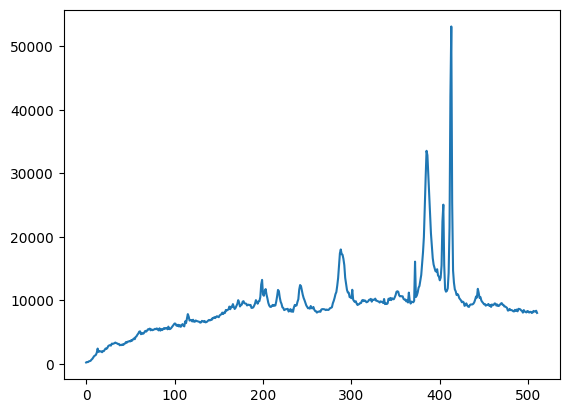

In [31]:
spectrum = img_bkg[250:260, :].sum(axis=0)
plt.plot(spectrum);

## The low-level Sherpa API

How about using the low-level API, as discussed in http://python4astronomers.github.io/fitting/low-level.html? Unlike
the `ui` layer, the data management here is explicit (i.e. I have to explicitly state what data is being used with that model and statistic when I perform a fit).

First, load in the parts of the API we are going to use, using a mixture of module imports and importing specific symbols:

In [32]:
from sherpa.data import Data1D
from sherpa.optmethods import LevMar
from sherpa.fit import Fit
from sherpa import models
from sherpa import stats

I reset the `x` and `y` variables to match the values used in the original fit above and use it
to create a `Data1D` object (the `ui.load_arrays` command also does this, but we don't see this unless
a routine like `ui.get_data` is used):

In [33]:
x = np.append(np.arange(10, 200), np.arange(300, 480))
y = img_cr[x, 10]
data = Data1D('row', x, y)

In [34]:
print(data)

name      = row
x         = Int64[370]
y         = Float32[370]
staterror = None
syserror  = None


In this case we do not use the error information since we are going to use
the `stats.LeastSq` least-squares statistic in the fit. Before we can fit,
we need a model:

In [35]:
mdl = models.Polynom1D('mdl')
mdl.c1.thaw()

In [36]:
mdl

<Polynom1D model instance 'mdl'>

Help on the model can be found by saying

    help(mdl)
    
but, as shown earlier, it's quite long so I won't repeat the information here.

Now that we have the data to fit, a model for the data, we can set up the fit
by also specifying the statistic and optimizer:

In [37]:
f = Fit(data, mdl, stats.LeastSq(), LevMar())

This has not actually run the fit yet; first we look at the `Fit` object:

In [38]:
print(f)

data      = row
model     = mdl
stat      = LeastSq
method    = LevMar
estmethod = Covariance


To fit the data we use the `fit` method and store the result, which contains information on whether
the fit succeeded and the model parameters; it is the same object as returned by 
`sherpa.astro.ui.fit`, seen above:

In [39]:
result = f.fit()

In [40]:
result

Parameter,Best-fit value,Approximate error
mdl.c0,22.3585,± 0.0980054
mdl.c1,-0.00227968,± 0.000341686


Note that the model has also been updated, so you can get the best-fit values
from either `result` or `mdl`:

In [41]:
mdl

<Polynom1D model instance 'mdl'>

Although we did not use the `guess` method here we get the same results
as with the `ui` version: $c_0 \sim 22.4$ and $c_1 \sim 0$.

Note that one difference is that the low-level interface does not set up
the Sherpa logging instance, so there is no screen output by default
here.

We can then fit the image using a similar loop as previously:

In [42]:
xrows = np.arange(img_cr.shape[0])
nbkg = np.zeros_like(img_cr)
nout0 = []
nout1 = []
for col in np.arange(img_cr.shape[1]):
    d = Data1D('col', x, img_cr[x, col])
    res = Fit(d, mdl, stats.LeastSq(), LevMar()).fit()
    nout0.append(mdl.c0.val)
    nout1.append(mdl.c1.val)
    nbkg[:, col] = mdl(xrows)

And a quick comparison of the results to show that they are essentially the same; the differences are very small, due to the fits not necessarily starting off from exactly the same place.

In [43]:
diff = bkg - nbkg

In [44]:
print("Max diff = {}".format(diff.max()))
print("Min diff = {}".format(diff.min()))

Max diff = 9.5367431640625e-07
Min diff = -9.5367431640625e-07


In [45]:
d0 = np.asarray(out0) - np.asarray(nout0)
print("Max difference for c0 = {}".format(d0.max()))
print("   % difference       = {}".format((100*d0/np.asarray(out0)).max()))

Max difference for c0 = 2.2940280786087897e-09
   % difference       = 4.8762350080056924e-08
